# ***Churn Prediction***

In [36]:
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns



*   loading the raw CSV file using pandas
*   low_memory=True is used to handle mixed type columns efficiently also im facing ram limitations




In [37]:
df = pd.read_csv("deepq_ai_assignment1_data.csv", low_memory=True)

Droping UID column...since its a unique identifier and not useful for prediction

df.drop(columns=["UID"], inplace=True)

Droping rows where the target column (label) is missing:

df = df.dropna(subset=["Target_ChurnFlag"])


In [38]:
df.drop(columns=["UID"], inplace=True)
df = df.dropna(subset=["Target_ChurnFlag"])


In [39]:
#downcasting all numeric columns to use less memory (float64 → float32, int64 → int32)
for col in df.select_dtypes(include=["float64", "int64"]).columns:
    df[col] = pd.to_numeric(df[col], downcast='float')

convertin all object type columns to categorical for LightGBM




In [40]:
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].astype("category")

set target and features


In [41]:
target = "Target_ChurnFlag"
X = df.drop(columns=[target])
y = df[target]

split into training and testing sets 80-20 split, stratified to keep label distribution)


In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


Initialise LightGBM model with parallel training support (n_jobs=-1)


In [43]:
model = LGBMClassifier(random_state=42, n_jobs=-1)
model.fit(X_train, y_train, categorical_feature="auto")

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 17002, number of negative: 24657
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.362885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36380
[LightGBM] [Info] Number of data points in the train set: 41659, number of used features: 189
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.408123 -> initscore=-0.371730
[LightGBM] [Info] Start training from score -0.371730


LGBMClassifier(n_jobs=-1, random_state=42)

train the model... LightGBM auto-detects categorical features if passed as 'category' dtype


In [44]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print classification metrics: precision, recall, f1-score, etc.

In [45]:
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.96      0.97      6165
         1.0       0.95      0.96      0.95      4250

    accuracy                           0.96     10415
   macro avg       0.96      0.96      0.96     10415
weighted avg       0.96      0.96      0.96     10415

ROC AUC Score: 0.9880860836792138


plot a heatmap of the confusion matrix

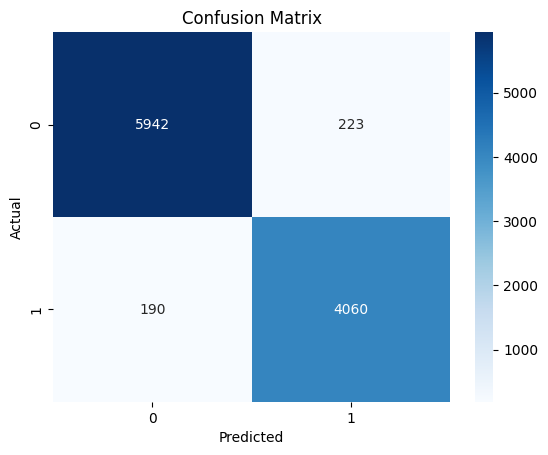

In [102]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

checking data leak

In [103]:
correlations = df.corr(numeric_only=True)['Target_ChurnFlag'].abs().sort_values(ascending=False)
print(correlations.head(10))

Target_ChurnFlag    1.000000
X19                 0.190396
X123                0.186854
X98                 0.169774
X102                0.161157
X104                0.158411
X132                0.134287
X128                0.133163
X215                0.129586
X127                0.127325
Name: Target_ChurnFlag, dtype: float64


In [104]:
import joblib
joblib.dump(model, "churn_model_lgbm.pkl")

['churn_model_lgbm.pkl']

In [49]:
if "Target_ChurnFlag" in df.columns:
    feature_columns = df.drop(columns=["Target_ChurnFlag"]).columns.tolist()
else:
    raise ValueError("Target_ChurnFlag not found in the DataFrame.")

In [50]:
importances = model.feature_importances_
top_features = pd.Series(importances, index=feature_columns).sort_values(ascending=False).head(15).index.tolist()

In [105]:
print("Top 15 important features:", top_features)

Top 15 important features: ['X16', 'X8', 'X7', 'X3', 'X4', 'X31', 'X2', 'X5', 'X85', 'X152', 'X6', 'X19', 'X98', 'X30', 'X124']


In [101]:
cols_to_display = ['X16', 'X8', 'X7', 'X3', 'X4', 'X31', 'X2', 'X5', 'X85', 'X152', 'X6', 'X19', 'X98', 'X30', 'X124', 'Target_ChurnFlag']

df_sample = df[cols_to_display].copy()
for col in df_sample.columns:
    if df_sample[col].dtype.name in ["object", "category"]:
        df_sample[col].fillna(df_sample[col].mode().iloc[0], inplace=True)
    else:
        df_sample[col].fillna(df_sample[col].median(), inplace=True)

sample_0 = df_sample[df_sample["Target_ChurnFlag"] == 0].sample(n=25, random_state=89)
sample_1 = df_sample[df_sample["Target_ChurnFlag"] == 1].sample(n=25, random_state=89)

balanced_sample = pd.concat([sample_0, sample_1]).sample(frac=1, random_state=42)

print(balanced_sample)

/tmp/ipython-input-101-394748564.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_sample[col].fillna(df_sample[col].mode().iloc[0], inplace=True)
/tmp/ipython-input-101-394748564.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(valu

              X16          X8          X7          X3          X4         X31  \
44710  2018-08-22  2016-04-27  2018-08-19  2018-08-21  2018-08-21  2018-08-21   
24450  2018-08-27  2020-05-04  2020-06-07  2021-01-03  2020-06-07  2020-06-07   
2899   2018-08-27  2017-09-06  2017-10-07  2018-07-07  2017-10-07  2017-10-07   
14106  2018-08-27  2019-05-18  2019-07-18  2019-07-18  2019-07-18  2019-07-18   
43195  2016-12-14  2016-04-27  2018-08-19  2016-12-13  2017-08-27  2016-12-13   
12579  2018-08-27  2019-10-23  2020-01-19  2020-01-19  2020-01-19  2020-01-19   
24787  2018-08-27  2017-04-01  2017-06-18  2017-06-18  2017-06-18  2017-06-18   
5027   2018-08-27  2020-03-15  2020-06-09  2020-06-20  2020-06-09  2020-06-09   
30650  2018-08-27  2019-06-07  2019-08-07  2020-05-11  2019-08-07  2019-08-07   
35015  2017-03-06  2016-04-27  2018-08-19  2017-03-05  2017-08-27  2017-03-05   
43313  2017-09-20  2016-04-27  2018-08-19  2017-09-19  2017-08-27  2017-09-19   
45699  2020-07-29  2016-04-2

,X16,X3,X2,X152,X98,X8,X4,X5,X6,X30,X7,X31,X85,X19,X124,Target_ChurnFlag
42303,2017-09-20,2017-09-24,2016-10-28,37211-6945,22.0,2017-07-25,2017-09-24,2016-10-28,2016-10-28,2016-10-28,2017-09-24,2017-09-24,0.000000,1.0,-1.000000,0.0
32755,2018-09-05,2018-09-24,2017-09-26,32792-8011,23.0,2018-06-19,2018-09-07,2016-07-21,2016-07-21,2017-09-26,2018-09-07,2018-09-07,2078.000000,2.0,14.000000,0.0
15441,2016-06-18,2016-07-19,2015-07-15,22192-1759,20.0,2016-06-06,2016-06-18,2015-07-15,2015-07-15,2015-07-15,2016-06-18,2016-06-18,2334.000000,1.0,-1.000000,0.0
31499,2019-08-05,2019-11-24,2018-10-23,32714-3253,22.0,2019-06-18,2019-08-05,2018-10-23,2018-10-23,2018-10-23,2019-08-05,2019-08-05,2100.000000,1.0,-1.000000,0.0
31169,2017-07-03,2017-12-10,2016-10-15,32714-3253,24.0,2017-06-03,2017-07-03,2016-10-15,2016-10-15,2016-10-15,2017-07-03,2017-07-03,0.000000,1.0,-1.000000,0.0
36197,2017-06-15,2017-06-21,2016-06-23,37075-2872,23.0,2017-03-25,2017-06-21,2016-06-23,2016-06-23,2016-06-23,2017-06-21,2017-06-21,1738.000000,1.0,-1.000000,0.0
47137,2018-12-18,2019-08-24,2018-08-28,98105-4714,22.0,2018-12-18,2018-12-18,2018-08-28,2018-08-28,2018-08-28,2018-12-18,2018-12-18,5876.000000,1.0,-1.000000,0.0
20286,2021-04-10,2021-05-24,2020-05-21,33510-4025,21.0,2021-02-23,2021-04-10,2020-05-21,2020-05-21,2020-05-21,2021-04-10,2021-04-10,2384.000000,1.0,-1.000000,0.0
11235,2019-09-04,2020-11-02,2019-09-03,93906-2861,42.0,2019-09-04,2019-09-04,2019-09-03,2019-09-03,2019-09-03,2019-09-04,2019-09-04,238.539993,1.0,-1.000000,0.0
34586,2020-02-21,2020-04-29,2019-05-02,37076-3246,48.0,2020-01-21,2020-02-22,2014-03-13,2014-03-13,2019-05-02,2020-02-22,2020-02-22,1978.000000,6.0,12.400000,0.0


In [74]:
categorical_columns = df.select_dtypes(include="category").columns.tolist()
joblib.dump(categorical_columns, "categorical_columns.pkl")

['categorical_columns.pkl']

In [76]:
df.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X206,X207,X208,X209,X210,X211,X212,X213,X214,X215
0,14 month lease,1103.0,2015-01-08,2016-02-28,2015-07-30,2015-01-08,2015-01-08,2015-07-30,2015-07-01,NaN,...,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,1.0,1.544818,1.000000,1.6625,0.600000
1,12 month lease,1136.0,2015-01-24,2016-01-17,NaN,2003-09-11,2003-09-11,NaN,NaN,NaN,...,0.013575,0.538462,0.0,1.307692,0.076923,1.0,1.591036,1.000000,1.6625,0.142857
2,12 month lease,1382.0,2015-02-20,2016-02-21,2016-02-21,2015-02-20,2015-02-20,NaN,NaN,NaN,...,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,1.0,1.303774,0.666667,1.6625,0.769231
3,14 month lease,2417.0,2015-02-06,2016-04-03,2016-04-04,2015-02-06,2015-02-06,2016-04-04,2016-03-02,2016-04-04,...,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,1.0,1.589636,1.000000,1.6625,0.750000
4,12 month lease,1405.0,2015-01-10,2016-01-03,NaN,2014-01-10,2014-01-10,NaN,NaN,2016-01-04,...,0.583333,3.000000,0.0,3.000000,1.000000,1.0,1.349664,1.000000,1.6625,0.700000
